# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Загрузка необходимых библиотек:

In [1]:
!pip install -q phik==0.11.1
!pip install -q scikit-learn==1.1.3
!pip install -q shap

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy import stats as st
import phik
import shap

In [2]:
# подготовка данных
from sklearn.model_selection import train_test_split
# модели
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PolynomialFeatures
# метрики регрессии
from sklearn.metrics import mean_absolute_error

In [3]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25         # Размер тестовой выборки
INVESTIG_POINTS = 500    # Cкважины при разведки региона
CHOSEN_POINTS = 200      # Cкважины для разработки в регионе
BS_SAMPLES = 1000        # Кол-во выборок для Bootstrap
BUDGET = 10E6            # Бюджет на разработку скважин в регионе
BARREL_PRICE = 450       # Цена одного барреля сырья 
LOSSES_PROP  = 0.025     # Предельная вероятность убытков

## Загрузка и подготовка данных

Чтение исходных данных в таблицы:

In [6]:
try:
    derrick1area = pd.read_csv('geo_data_0.csv')
    derrick2area = pd.read_csv('geo_data_1.csv')
    derrick3area = pd.read_csv('geo_data_2.csv')
except:
    derrick1area = pd.read_csv('/datasets/geo_data_0.csv')
    derrick2area = pd.read_csv('/datasets/geo_data_1.csv')
    derrick3area = pd.read_csv('/datasets/geo_data_2.csv')

Выполним небольшую предобработку данных, хотя данные не разнообразны и скорее всего проблем нет.

In [74]:
table_set = [derrick1area, derrick2area, derrick3area]
table_names =  ['группа скважин-1', 'группа скважин-2', 'группа скважин-3']

In [8]:
[display(item.sample(3)) for item in table_set];   

,id,f0,f1,f2,product
2908,nt6bd,-0.874045,0.661676,-3.119213,85.118805
32059,C87yu,0.867150,0.376228,2.241822,132.978567
44977,K2SDx,1.973347,0.166630,0.424568,22.483404


,id,f0,f1,f2,product
49225,8VtWc,-9.240382,0.657135,4.000060,110.992147
2546,jVLcQ,-6.737055,-13.116626,5.003143,137.945408
57615,503Sp,7.762190,1.264216,4.005840,107.813044


,id,f0,f1,f2,product
47459,IyiGf,0.800114,-0.884744,-0.326466,40.025114
15029,x2ugd,-0.394270,0.001358,3.506762,0.790283
32247,Av7V0,-0.383178,-1.009464,3.073947,82.828308


 - Все таблицы содержат одинаковые столбцы, в том числе id номер скважины;
 - Все основные данные числовые непрерывные.

In [9]:
[item.info() for item in table_set];

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

 - Пропусков в данных нет

Проверим данные на наличие явных дубликатов:

In [10]:
[print('Количество дубликатов по таблицам:', '"', table_names[i], '"' ,item.duplicated().sum()) for i, item in enumerate(table_set)]; 

Количество дубликатов по таблицам: " группа скажин-1 " 0
Количество дубликатов по таблицам: " группа скажин-2 " 0
Количество дубликатов по таблицам: " группа скажин-3 " 0


 - Явных дубликатов нет

Возможно оставить индексацию по номеру, а можно перейти к индексации по 'id' - что имеет больше смысла (в том числе сразу исключаем id из списка признаков при обучении модели - это не проблема но что тянуть)

In [11]:
[item.set_index('id', inplace=True) for item in table_set];

In [12]:
table_set = [derrick1area, derrick2area, derrick3area];

Проверим на дубликаты в данных еще раз без учета 'id' потому, что он не является значимым признаком, а чтобы не переобучить модель на тренеровочной выборке их не должно быть. Хотя на выборки делим позже, но проверить сейчас нам ничего не мешает.

In [13]:
[print('Количество дубликатов по таблицам:', '"', table_names[i], '"' ,item.duplicated().sum()) for i, item in enumerate(table_set)]; 

Количество дубликатов по таблицам: " группа скажин-1 " 0
Количество дубликатов по таблицам: " группа скажин-2 " 0
Количество дубликатов по таблицам: " группа скажин-3 " 0


 - И здесь явных дубликатов нет

Исследуем распределение признаков скважин по месторождениям.

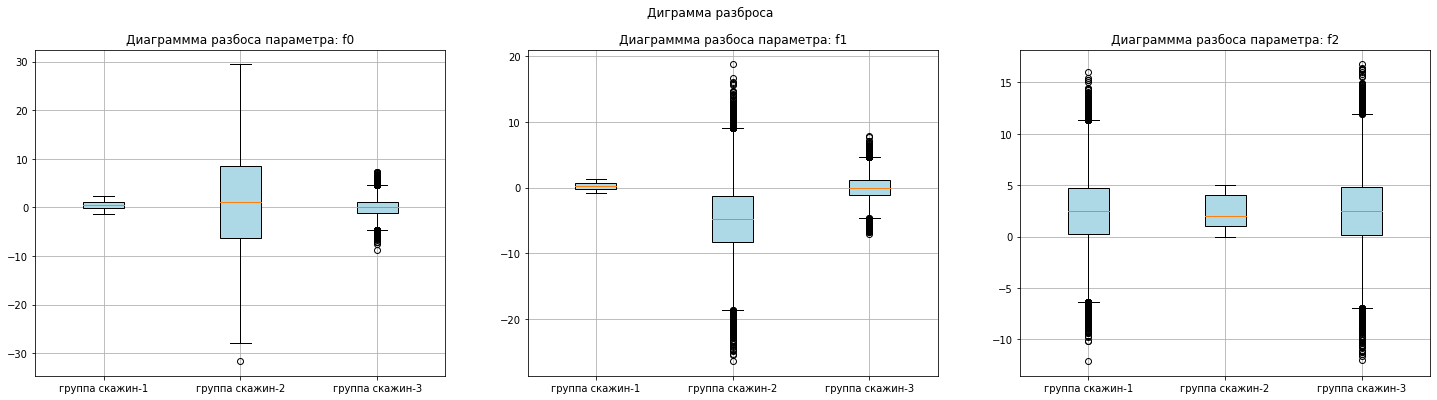

In [13]:
cols = ['f0', 'f1', 'f2']
n = len(cols)
fig, ax = plt.subplots(1, n, figsize=(25, 6))
fig.suptitle('Диграмма разброса')
boxprops = dict(facecolor = "lightblue")
for i, col in enumerate(cols):
    dic = {}
    for j in range(3):
        dic[table_names[j]]=table_set[j][col]
    ax[i].boxplot(dic.values(), patch_artist = True, boxprops= boxprops)
    ax[i].set_xticklabels(dic.keys())
    ax[i].set_title('Диаграммма разбоса параметра: '+ cols[i])
    ax[i].grid()
plt.show()

Интересно, что все группы скважин различаются, при этом группа 1 и группа 3 более "похожи" друг на друга.

Посмотрим что с целевым признаком:

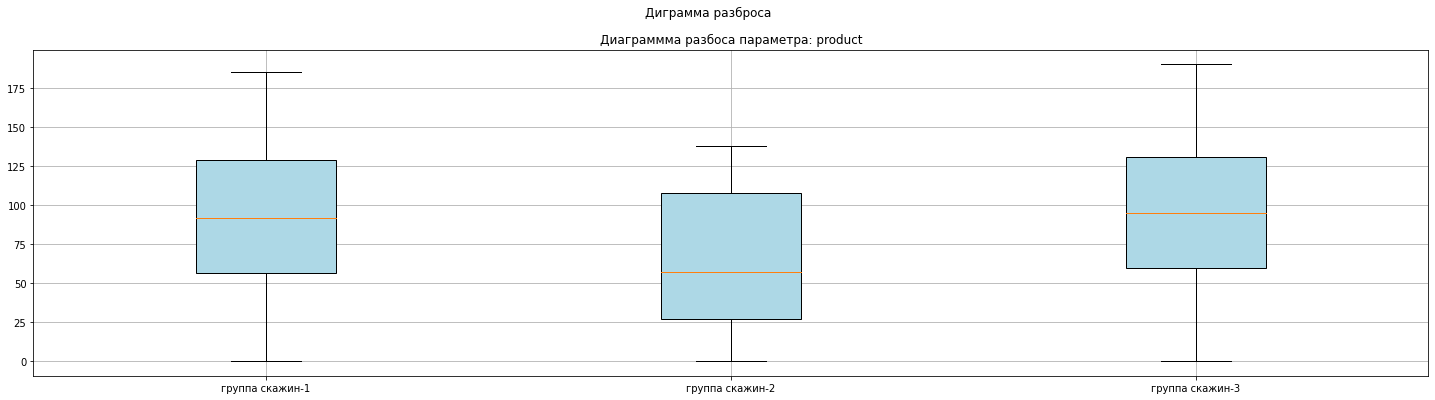

In [14]:
cols = 'product'
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
fig.suptitle('Диграмма разброса')
boxprops = dict(facecolor = "lightblue")
dic = {}
for j in range(3):
    dic[table_names[j]]=table_set[j][cols]
ax.boxplot(dic.values(), patch_artist = True, boxprops= boxprops)
ax.set_xticklabels(dic.keys())
ax.set_title('Диаграммма разбоса параметра: '+ cols)
ax.grid()
plt.show()

- В принципе можно сразу сказать, что в среднем произодство для второй группы скважин будет ниже чем для первой и третьей;
- Первая и третья группа как по распределению признаков так и целевого значения похожи - нужно посмотреть что сможет спрогнозировать модель.

Выведем описание числовых столбцов

In [16]:
[display(item.describe()) for item in table_set];  

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Здесь интересны скважины с нулевой производительностью:

In [17]:
[display(item.loc[item['product']==0].head(5)) for item in table_set];

,f0,f1,f2,product
id,,,,
zCM5W,-0.702064,0.375992,0.236572,0.0


,f0,f1,f2,product
id,,,,
OXyvW,16.320755,-0.562946,-0.001783,0.0
igmai,6.695604,-0.749449,-0.007630,0.0
Qjy5w,21.418478,-5.134490,-0.002836,0.0
G6WCj,6.822701,3.104979,-0.000723,0.0
MzQhL,6.750150,-11.893512,-0.001601,0.0


,f0,f1,f2,product
id,,,,
qeefd,-0.865596,-1.615247,-4.126441,0.0


Интересно, что у всех значений "product" = 0, значения "f2" во второй группе скважин тоже около нуля - построим распределение "f2".

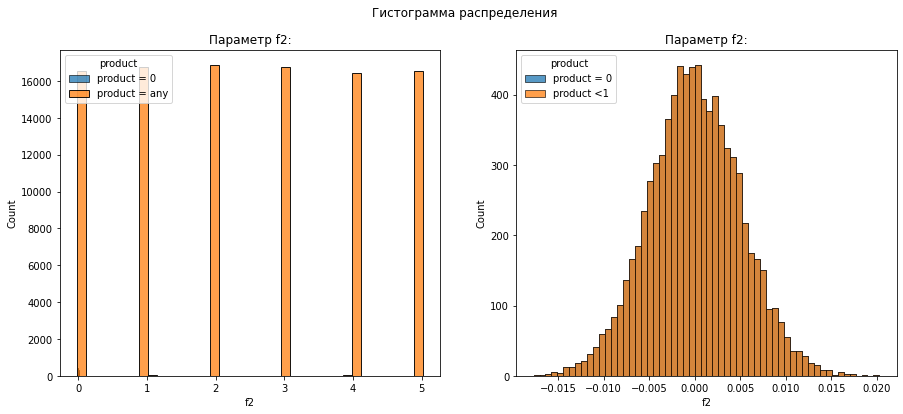

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Гистограмма распределения')
[sns.histplot(data=derrick2area.loc[derrick2area['product']==0], x='f2', ax=ax[i], color='tab:blue') for i in range(2)]
sns.histplot(data=derrick2area, x='f2', color='tab:orange', ax=ax[0])
sns.histplot(data=derrick2area.loc[derrick2area['product']<1], x='f2', color='tab:orange', ax=ax[1])
[ax[i].set_title('Параметр f2:') for i in range(2)]
ax[0].legend(title='product', loc='upper left', labels=['product = 0', 'product = any'])
ax[1].legend(title='product', loc='upper left', labels=['product = 0', 'product <1'])
plt.show()

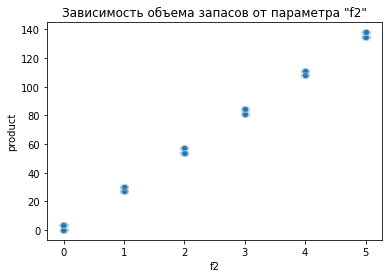

In [19]:
sns.scatterplot(data=derrick2area, x='f2', y='product', alpha=0.5);
plt.title('Зависимость объема запасов от параметра "f2"')
plt.show()

Скорее всего эта корреляция определит точность модели.

Таким образом:

   - для второй группы обнаружено значительное количество скважин(примерно 1/6) с нулевой производительностью;
   - для второй группы параметр "f2" распределен практически дискретно и концентрируется в районе целочисленных значений(в отличии от группы 1 и 3);
   - существует соответствие между "product" и значениями "f2", при этом для двух других месторождений такая связь менее выражена.
    


Было бы неплохо уточнить у заказчика - "почему так ?" или хотя бы обратить его внимание  на этот факт. Но пока лишь констатируем данную закономерность и продолжим анализ и построение модели.

Так как поставлено условием использование линейной регрессионной модели, целесообразно проверить наличие мультиколлинеарности признаков, которых три для каждой группы скважин:

In [20]:
def heatplot_tab(data, ax , name):
    corr_market = data.phik_matrix(interval_cols= ['f0', 'f1', 'f2']);
    sns.heatmap(
        corr_market,        
        cmap='RdBu_r',                
        annot=True,
        ax=ax,
        vmin=-1, vmax=1              
        );
    ax.set_title('Тепловая карта коэффициентов корреляции phik для : ' + name)

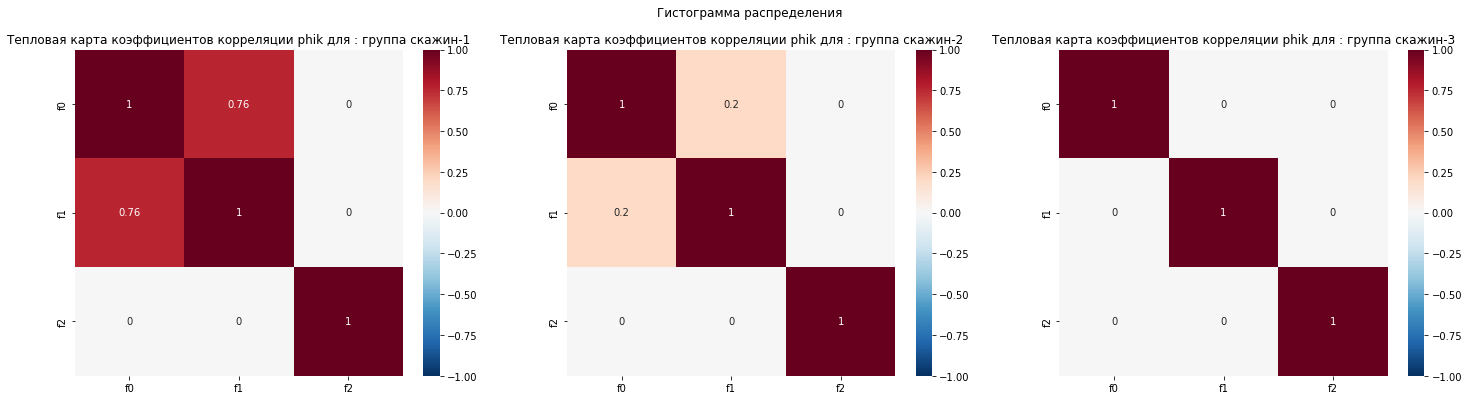

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
fig.suptitle('Гистограмма распределения')
[heatplot_tab(item[['f0', 'f1', 'f2']], ax[i], table_names[i]) for i, item in enumerate(table_set)];
plt.show();

 - Только для первой группы скважин наблюдается сильная взаимосвязь параметра "f0" и "f1" в остальных случая все хорошо (даже идеально для группы 3 - что противоестественно 😀);
 - Считает, что мультиколлинеарность соответствует значениям более 0.9 - поэтому удалять признаки не будем.

**Выводы:** 
 - Данные загружены и обработаны, противоречий нет, не выявлено наличие Nan или иных дефектов;
 - Корреляция между параметрами находится на приемлемом уровне;
 - Отмечена особенность в данных для второй группы скважин.

## Обучение и проверка модели

Выделим признаки и целевой параметр 'product':

In [22]:
argument_col = derrick1area.columns
target = 'product'
argument_col = argument_col[~np.isin(argument_col, target)]

### Создание pipeline для модели линейной регрессии

In [23]:
def prediction_model(X_num, NumScaler, model_step):
    # выбор масшабирования
    if NumScaler == 'Standart':
        Scaler = StandardScaler()
    elif NumScaler == 'Robust': 
        Scaler = RobustScaler()    
    elif NumScaler == 'Quantile': 
        Scaler = QuantileTransformer()
    else:
        Scaler = MinMaxScaler()
    # обработка входных данных
    num_features = X_num.tolist()
    # преобразование численных признаков
    num_steps = [('SimpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('Scaler', Scaler)]
    num_transformer = Pipeline(num_steps)
    # создаём общий пайплайн для подготовки данных
    data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features)],        
          remainder='passthrough')
    # создаём итоговый пайплайн по шагам
    step_prep = ('preprocessor', data_preprocessor)
    # выбор модели 
    if   model_step == 'LinearRegression':
        step_sol  = ('model', LinearRegression(n_jobs=-1))
    elif model_step == 'DummyRegressor':
        step_sol  = ('model', DummyRegressor(strategy="mean"))
    # собираем шаги модели
    pipe_final = Pipeline([step_prep, step_sol])
    return pipe_final

Например можно получить такую модель (оставим SimpleImputer - хотя данные не содержат пропусков - пусть будет )

In [25]:
##Scalers -  Standart/Robust/Quantile/Min/Max - лучший вариант оказался с 'Min/Max'
lin_model = prediction_model(argument_col, 'Min/Max', 'LinearRegression')
lin_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('SimpleImputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', LinearRegression(n_jobs=-1))])

In [26]:
dummy_test_model = prediction_model(argument_col, 'Min/Max', 'DummyRegressor')

### Формирование обучающих и валидационных выборок в соотношении 75:25

In [28]:
def get_spliting (arguments, target):
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(arguments, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    return Xtrain, Xtest, Ytrain, Ytest

In [29]:
Xtrain1a, Xtest1a, Ytrain1a, Ytest1a = get_spliting(derrick1area[argument_col], derrick1area[target])
Xtrain2a, Xtest2a, Ytrain2a, Ytest2a = get_spliting(derrick2area[argument_col], derrick2area[target])
Xtrain3a, Xtest3a, Ytrain3a, Ytest3a = get_spliting(derrick3area[argument_col], derrick3area[target])

Постараемся сделать в цикле для всех трех групп скважин

In [32]:
Xtrain = [Xtrain1a, Xtrain2a, Xtrain3a]
Xtest  = [Xtest1a, Xtest2a, Xtest3a]
Ytrain = [Ytrain1a, Ytrain2a, Ytrain3a]
Ytest  = [Ytest1a, Ytest2a, Ytest3a]

In [36]:
metrics = []
for i, model in enumerate(table_names):
    lin_model.fit(Xtrain[i], Ytrain[i])
    Ytest_predict = lin_model.predict(Xtest[i])
    r2_score  =  lin_model.score(Xtest[i], Ytest[i])
    rmse_score =  np.sqrt(mean_absolute_error(Ytest[i], Ytest_predict))
    dummy_test_model.fit(Xtrain[i], Ytrain[i])
    Ytest_predict_dummy =  dummy_test_model.predict(Xtest[i])
    rmse_score_dummy    =  np.sqrt(mean_absolute_error(Ytest[i], Ytest_predict_dummy))
    metrics.append([str(lin_model.get_params()['model']), r2_score, rmse_score, rmse_score_dummy])
metrics = pd.DataFrame(metrics)
metrics.columns = ['Модель', 'Метрика R2', 'Метрика RMSE', 'Метрика RMSE(Dummy)']
metrics.index  = table_names
metrics

,Модель,Метрика R2,Метрика RMSE,Метрика RMSE(Dummy)
группа скажин-1,LinearRegression(n_jobs=-1),0.272829,5.572045,6.135782
группа скажин-2,LinearRegression(n_jobs=-1),0.999625,0.846766,6.348551
группа скажин-3,LinearRegression(n_jobs=-1),0.196347,5.735587,6.150650


Можно отметить, что:
   - для "группы скважин-2" высокое значение коэффициента детерминации говорит о наличии практически однозначного соответствия между признаками и целевым параметром;
   - предсказания для моделей "группа скажин-1" и "группа скажин-3" немногим лучше константной модели DummyRegressor
    

### Подбор признаков

Скорее всего с такими данными ничего не поможет, но можно попробовать поискать нелинейные зависимости, добавив полиномиальные признаки с помощью PolynomialFeatures (выполним для третьей группы скважин и посмотрим, что получится на остальных)

In [37]:
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(Xtrain[2])
X_test = poly.transform(Xtest[2])

In [38]:
X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())
X_test  = pd.DataFrame(X_test, columns = poly.get_feature_names_out())
Y_train = Ytrain[2]
Y_test  = Ytest[2]

In [39]:
drop_cols = []
cols = X_train.columns[~np.isin(X_train.columns, drop_cols)]
lin_model = prediction_model(cols, 'Min/Max', 'LinearRegression')
lin_model.fit(X_train[cols], Y_train)
Y_test_predict = lin_model.predict(X_test)
r2_score  =  lin_model.score(X_test[cols], Y_test)
rmse_score =  np.sqrt(mean_absolute_error(Y_test, Y_test_predict))
print('Метрика R2 для третьей группы скважин', r2_score)
print('Метрика RMSE для третьей группы скважин', rmse_score)

Метрика R2 для третьей группы скважин 0.2462627802574744
Метрика RMSE для третьей группы скважин 5.65983976805112


Попробуем отсеять признаки с помощью SHAP

In [40]:
X_train_scaled = lin_model['preprocessor'].fit_transform(X_train[cols])
model  = lin_model['model']
prepr =  lin_model['preprocessor']

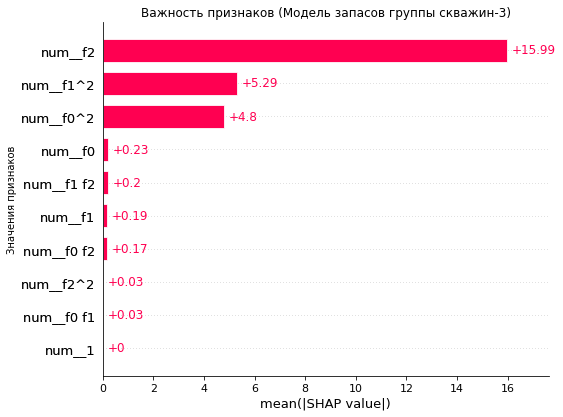

CPU times: total: 2.77 s
Wall time: 2.76 s


In [41]:
%%time
explainer = shap.Explainer(model, X_train_scaled)
feature_names = prepr.get_feature_names_out()
X_train_scaled = pd.DataFrame(X_train_scaled, columns = feature_names)
plt.title('Важность признаков (Модель запасов группы скважин-3)')
plt.ylabel('Значения признаков')
shap.plots.bar(explainer(X_train_scaled))
plt.show()

Таким образом, можно отбросить следующие признаки (но все таки оставим изначальные):

In [42]:
drop_cols = ['1', 'f0 f1', 'f1 f2', 'f0 f2']

In [43]:
cols = X_train.columns[~np.isin(X_train.columns, drop_cols)]
lin_model = prediction_model(cols, 'Min/Max', 'LinearRegression')
lin_model.fit(X_train[cols], Y_train)
Y_test_predict = lin_model.predict(X_test)
r2_score  =  lin_model.score(X_test[cols], Y_test)
rmse_score =  np.sqrt(mean_absolute_error(Y_test, Y_test_predict))
print('Метрика R2 для третьей группы скважин', r2_score)
print('Метрика RMSE для третьей группы скважин', rmse_score)

Метрика R2 для третьей группы скважин 0.24630957022531197
Метрика RMSE для третьей группы скважин 5.659759095906094


 - Как было отмечено ранее основное влияние оказывет параметр "f2";
 - Использование полиномизации признаков позволило на 5% улучшить качество модели для третьей группы скважин.

###  Предсказания, правильные ответы на валидационной выборке и средний запас предсказанного сырья с RMSE модели.

Тогда итоговый вариант моделей будет выглядеть следующим образом:

In [44]:
validation_rez = pd.DataFrame()
metrics = []
for i, name in enumerate(table_names):
    X_train = poly.fit_transform(Xtrain[i])
    X_test = poly.transform(Xtest[i])
    X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())
    X_test  = pd.DataFrame(X_test, columns = poly.get_feature_names_out())
    lin_model.fit(X_train[cols], Ytrain[i])
    Ytest_predict = lin_model.predict(X_test[cols])
    r2_score  =  lin_model.score(X_test[cols], Ytest[i])
    rmse_score =  np.sqrt(mean_absolute_error(Ytest[i], Ytest_predict))
    metrics.append([str(lin_model.get_params()['model']), r2_score, rmse_score])
    validation_rez[name+' index'] = Ytest[i].index
    validation_rez[name+' true'] = Ytest[i].values
    validation_rez[name+' predicted'] = Ytest_predict
metrics = pd.DataFrame(metrics)
metrics.columns = ['Модель', 'Метрика R2', 'Метрика RMSE']
metrics.index  = table_names
display(metrics)
validation_rez.head(5)

,Модель,Метрика R2,Метрика RMSE
группа скажин-1,LinearRegression(n_jobs=-1),0.272844,5.571931
группа скажин-2,LinearRegression(n_jobs=-1),0.999625,0.846764
группа скажин-3,LinearRegression(n_jobs=-1),0.246310,5.659759


,группа скажин-1 index,группа скажин-1 true,группа скажин-1 predicted,группа скажин-2 index,группа скажин-2 true,группа скажин-2 predicted,группа скажин-3 index,группа скажин-3 true,группа скажин-3 predicted
0,7C6bA,122.073350,102.021311,fYVDK,0.000000,0.842324,sPjbT,117.441301,100.452140
1,dVxsn,48.738540,78.448272,3SQcq,53.906522,52.924591,1u4uo,47.841249,93.343486
2,1Gm3l,131.338088,115.355655,hQ1gJ,134.766305,135.107791,kZ6HO,45.883483,54.131372
3,Nzg1t,88.327757,105.455945,Y4vux,107.813044,109.493186,gCZGK,139.014608,110.653410
4,Z7b4F,36.959266,97.740295,H1NUw,0.000000,-0.045065,rqJHx,84.004276,78.313991


Можно еще догнать полиномы до 4 степени и улучшить показатели модели на порядка 1 %............ но не нужно 

Разобьем большую таблицу по отдельных группам скважин.

In [45]:
derrick1predict=derrick2predict=derrick3predict= pd.DataFrame()
list0pd = [derrick1predict, derrick2predict, derrick3predict]
for i, df in enumerate(list0pd):
    shift = 3*i
    list0pd[i] = validation_rez[validation_rez.columns[0+shift:3+shift]]
    list0pd[i].columns =  ['id', 'true', 'predicted']
[derrick1predict, derrick2predict, derrick3predict] = list0pd
[item.set_index('id', inplace=True) for item in [derrick1predict, derrick2predict, derrick3predict]];
[display(item.head(3)) for item in [derrick1predict, derrick2predict, derrick3predict]];

,true,predicted
id,,
7C6bA,122.073350,102.021311
dVxsn,48.738540,78.448272
1Gm3l,131.338088,115.355655


,true,predicted
id,,
fYVDK,0.000000,0.842324
3SQcq,53.906522,52.924591
hQ1gJ,134.766305,135.107791


,true,predicted
id,,
sPjbT,117.441301,100.452140
1u4uo,47.841249,93.343486
kZ6HO,45.883483,54.131372


Для итоговой модели выполним анализ остатков и их дисперсии по каждой группе

In [46]:
to_post = [derrick1predict['true']-derrick1predict['predicted'], 
           derrick2predict['true']-derrick2predict['predicted'], 
           derrick3predict['true']-derrick3predict['predicted']]

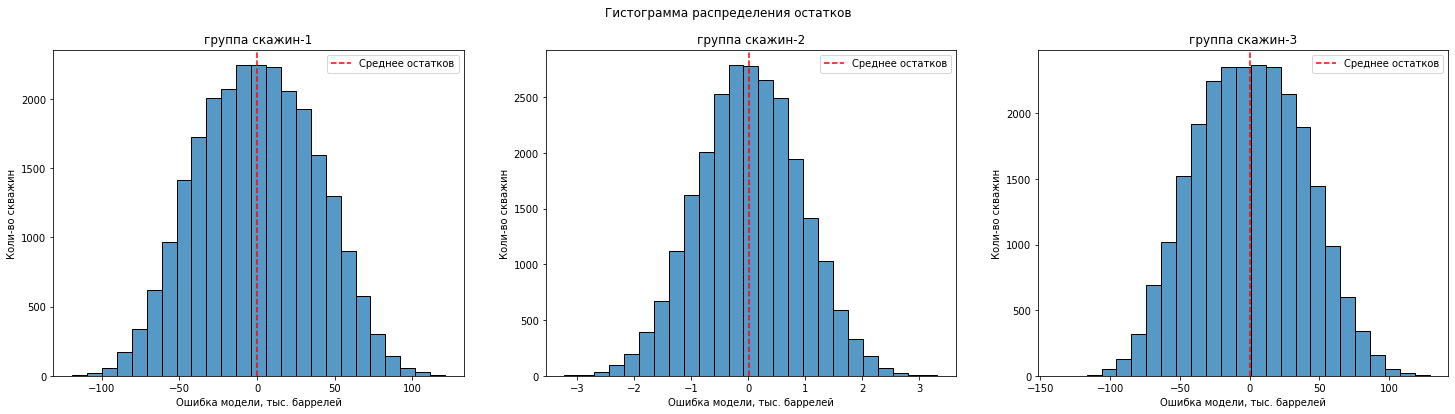

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
fig.suptitle('Гистограмма распределения остатков')
for i in range(3):
    sns.histplot(data=to_post[i], bins=25, ax= ax[i])
    ax[i].axvline(x = to_post[i].mean(), color = 'r', linestyle='dashed')
    ax[i].set_title(table_names[i])
    ax[i].legend(['Среднее остатков'])
    ax[i].set_ylabel('Коли-во скважин')
    ax[i].set_xlabel('Ошибка модели, тыс. баррелей')
plt.show()

Cредние значения около 0, так что модель практически не завышает и одновременно не занижает показания - это хорошо. У модели для второй группы скажин ошибка минимальна. Для первой и третьей группы остатки практически одинаковы, но ошибки принципиально больше

Оценим постоянство дисперсии

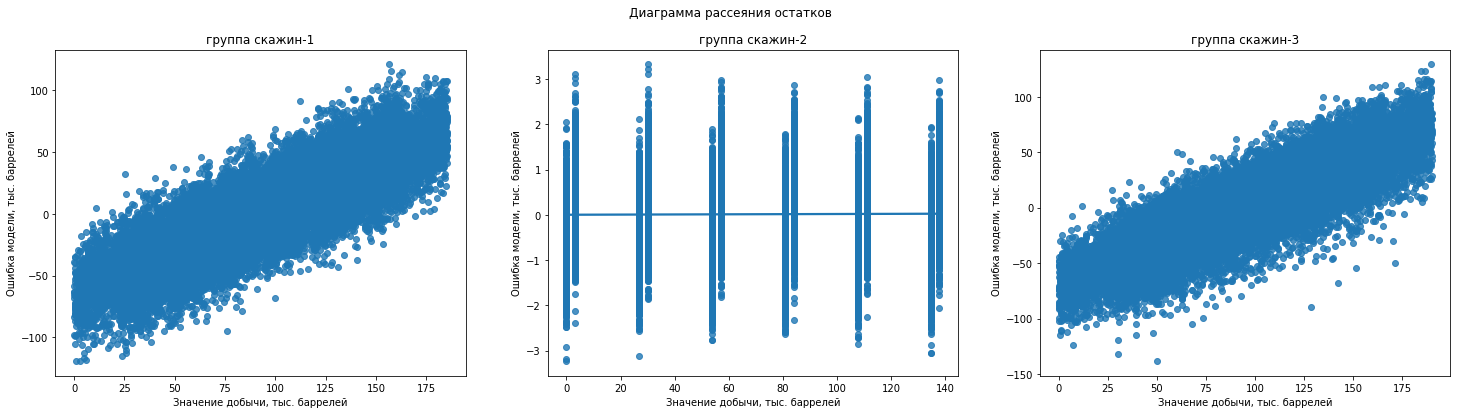

In [267]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
fig.suptitle('Диаграмма рассеяния остатков')
for i in range(n):
    sns.regplot(x=list0pd[i]['true'], y=to_post[i], ax=ax[i])
    ax[i].set_title(table_names[i])
    ax[i].set_ylabel('Ошибка модели, тыс. баррелей')
    ax[i].set_xlabel('Значение добычи, тыс. баррелей')
plt.show()

Для первой и третьей группы разброс остатков постоянный, но среднее значение увеличивается в ростом добычи (но исследовать это не будем).

Оценим средние значения запасов сырья по группам скважин:

In [76]:
accumulated_data = pd.DataFrame()
accumulated_data['Cредний запас сырья, тыс. баррелей'] = (validation_rez[validation_rez.columns[['true' in name for name in validation_rez.columns]]].sum()).values/validation_rez.shape[0]
accumulated_data['Cредний запас предсказанного сырья, тыс. баррелей'] = (validation_rez[validation_rez.columns[['predicted' in name for name in validation_rez.columns]]].sum()).values/validation_rez.shape[0]
accumulated_data.index = table_names
accumulated_data['Метрика RMSE'] = metrics['Метрика RMSE'].values.round(2)
accumulated_data.sort_values(by = 'Cредний запас предсказанного сырья, тыс. баррелей', ascending=False).T

,группа скважин-3,группа скважин-1,группа скважин-2
"Cредний запас сырья, тыс. баррелей",95.150999,92.325956,68.725381
"Cредний запас предсказанного сырья, тыс. баррелей",94.760501,92.400454,68.712876
Метрика RMSE,5.660000,5.570000,0.850000


Таким образом, лучшие показатели по среднему запасу предсказанного сырья показала группа скважин 3, далее группа скважин 1 и группа скважин 2

**ВЫВОДЫ**
 - Обучена модель линейной регрессии;
 - использование полиномизации позволило повысить качество модели на 5% для третьей группы скважин;
 - сохранены предсказания и правильные ответы на валидационной выборке;
 - получены значения средного запаса предсказанного сырья и RMSE модели (представлены в итоговой таблице);
 - отмечено высокое качество модели для второй группы скважин и посредственное для первой и третьей группы.

## Расчёт прибыли

Ключевые значения для расчета объявлены в начале исследования.

###  Достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.

Будем считать, что минимальное среднее количество продукта в месторождениях региона, достаточное для разработки определяется исходя из нулевого значения ROI («возврат на инвестиции») при текущей цене барреля нефти. То есть итоговая прибыль в пределе должна быть равна инвестициям:

In [56]:
total_product = BUDGET/BARREL_PRICE
print('Необходимое количество добытой нефти с группы скважин, тыс. баррелей:', round(total_product,2))

Необходимое количество добытой нефти с группы скважин, тыс. баррелей: 22222.22


Сравним полученный объём сырья со средним запасом в каждом регионе(по предсказанным моделью данным)

In [77]:
accumulated_data['Кол-во скважин для безубыточности, шт'] = np.floor(total_product/accumulated_data['Cредний запас предсказанного сырья, тыс. баррелей'])
accumulated_data.T

,группа скважин-1,группа скважин-2,группа скважин-3
"Cредний запас сырья, тыс. баррелей",92.325956,68.725381,95.150999
"Cредний запас предсказанного сырья, тыс. баррелей",92.400454,68.712876,94.760501
Метрика RMSE,5.570000,0.850000,5.660000
"Кол-во скважин для безубыточности, шт",240.000000,323.000000,234.000000


Вывод: 
 - Исходя из средней производительности скважин в группах не удается обеспечить безубыточность производства на 200 скважинах. 

### Расчёт прибыли по лучшим 200 предсказанным скважинам для каждой группы

Чистая прибыль учитывает почти все показатели бизнеса: себестоимость, операционные расходы, платежи государству и кредиторам. Поэтому из доходов от продажи нефти вычтем затраты на разработку. Тут странно, но: 

 - x.1 Выберите скважины с максимальными значениями предсказаний;
 - x.2 Просуммируйте целевое значение объёма сырья, соответствующее этим предсказания;
 - x.3 Рассчитайте прибыль для полученного объёма сырья.


In [79]:
def get_profit (data):
    sorted_data = data.sort_values(by = 'predicted', ascending=False)
    product = (sorted_data[:CHOSEN_POINTS])['true'].sum()
    income = product*BARREL_PRICE
    return (income-BUDGET)/1000

In [81]:
accumulated_data['Прибыль, млн'] = [get_profit(item) for item in [derrick1predict, derrick2predict, derrick3predict]];
accumulated_data.T

,группа скважин-1,группа скважин-2,группа скважин-3
"Cредний запас сырья, тыс. баррелей",92.325956,68.725381,95.150999
"Cредний запас предсказанного сырья, тыс. баррелей",92.400454,68.712876,94.760501
Метрика RMSE,5.570000,0.850000,5.660000
"Кол-во скважин для безубыточности, шт",240.000000,323.000000,234.000000
"Прибыль, млн",3344.422316,2415.086697,2888.023863


**Выводы**
 - Исходя из **средней производительности** скважин в группах не удается обеспечить безубыточность производства на 200 скважинах;
 - По **средней производительность** лучшая группа - третья, далее первая и вторая; 
 - Если бы удалось выбрать **самые лучшие** предсказанные скважины, наибольшая прибыль соответствовала бы первой группе скважин, далее третья и вторая группа;
 - Низкий уровень прибыли со второй группы скважин определяется не точностью модели, а невысоким уровнем запаса сырья;
 - Низкая точность модели для первой и третьей группы в предсказании прибыли для 200 лучших скважин, компенсируется низких уровнем запаса для второй группы, которая в итоге и проигрывает.

## Расчёт прибыли и рисков 

Найдем распределение средней прибыли с помощью Bootstrap на 1000 выборок для 500 скважин.

### Генерация выборок с помощью Bootstrap с 1000 выборок

In [82]:
state = np.random.RandomState(RANDOM_STATE)

Создадим функцию для генерации выборок и далее в цикле выполним ее для всех трех групп скважин

In [84]:
def get_bootstrap_distribution(data):
    profit = np.zeros((BS_SAMPLES, 1))
    for i in range(BS_SAMPLES):
        subsamples_index =(data.sample(n=INVESTIG_POINTS, replace=True, random_state=state)).index
        subsample =  data.loc[subsamples_index]
        profit[i] = get_profit(subsample)
    profit = pd.DataFrame(profit)
    profit.columns = ['средняя прибыль']
    return profit

In [85]:
derrick1_dist = derrick2_dist=derrick3_dist= pd.DataFrame()
list0dist = [derrick1_dist, derrick2_dist, derrick3_dist]
for i, df in enumerate([derrick1predict, derrick2predict, derrick3predict]):
    list0dist[i] = get_bootstrap_distribution(df)
[derrick1_dist, derrick2_dist, derrick3_dist] = list0dist

Построим гистограммы распределения прибыли для всех трех групп:

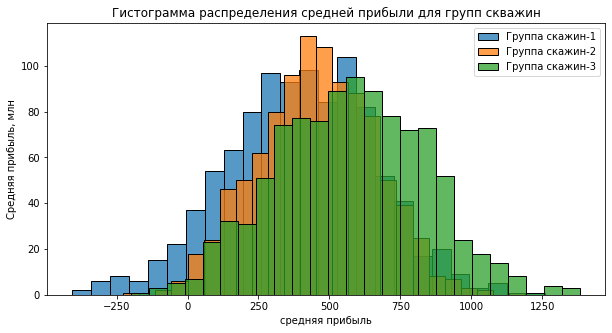

In [87]:
plt.figure(figsize=(10,5))
sns.histplot(data=derrick1_dist, x ='средняя прибыль', bins = 25, label='Группа скажин-1')
sns.histplot(data=derrick2_dist, x ='средняя прибыль', bins = 25, label='Группа скажин-2')
sns.histplot(data=derrick3_dist, x ='средняя прибыль', bins = 25, label='Группа скажин-3')
plt.title ('Гистограмма распределения средней прибыли для групп скважин')
plt.ylabel('Средняя прибыль, млн')
plt.legend()
plt.show()

### Cредняя прибыль, 95%-й доверительный интервал и риск убытков.

Посчитаем в цикле средную прибыль для случайной выборки из 500 скважин, 95 процентный доверительный интервал и риск возникновения убытков.

In [88]:
comparation_tab = []
for i, item in enumerate(list0dist):
    comparation_tab.append([item.mean().values[0], [item.quantile(0.025).values[0].round(2), 
                            item.quantile(0.975).values[0].round(2)], 
                            item.quantile(0.975).values[0]-item.quantile(0.025).values[0],
                            item.loc[item['средняя прибыль']<0].count().values[0]/BS_SAMPLES*100])
comparation_tab = pd.DataFrame(comparation_tab)
comparation_tab.columns = ['Среднее значение прибыли для случайной выборки, млн', 
                           'Границы 95%-ого доверительного интервала, млн',
                           'Ширина 95%-ого доверительного интервала, млн',
                           'Вероятность отрицательной прибыли, %']
comparation_tab.index = table_names
comparation_tab.T

,группа скважин-1,группа скважин-2,группа скважин-3
"Среднее значение прибыли для случайной выборки, млн",399.087502,452.576594,575.662222
"Границы 95%-ого доверительного интервала, млн","[-121.54, 897.46]","[52.31, 830.15]","[74.55, 1072.16]"
"Ширина 95%-ого доверительного интервала, млн",1019.003727,777.836903,997.617297
"Вероятность отрицательной прибыли, %",6.2,0.9,0.9


**Выводы**

 - Самый большой риск убытков соответствует первой группе скважин и достигает {{ comparation_tab['Вероятность отрицательной прибыли, %']['группа скважин-1'] }} процентов;
 - Самый низкий риск убытков соответствует второй группе скважин {{ comparation_tab['Вероятность отрицательной прибыли, %']['группа скважин-2'] }}, сопоставимый с ним уровень для третьей группы {{ comparation_tab['Вероятность отрицательной прибыли, %']['группа скважин-3'] }};
 - Для второй группы скважин самый "узкий" доверительный интервал {{ comparation_tab['Ширина 95%-ого доверительного интервала, млн']['группа скважин-2'] }}, что определяется высокой предсказательной способностью используемой модели;
 - Ширина доверительного интервала для первой и третьей группы - {{ comparation_tab['Ширина 95%-ого доверительного интервала, млн']['группа скважин-1'] }} и {{ comparation_tab['Ширина 95%-ого доверительного интервала, млн']['группа скважин-3'] }}сопоставимы, соответственно;
 - самое высокий уровень прибыли на случайной выборке найден для третьей группы скважин {{ comparation_tab['Среднее значение прибыли для случайной выборки, млн']['группа скважин-3'] }}, далее первая группа с {{ comparation_tab['Среднее значение прибыли для случайной выборки, млн']['группа скважин-1'] }} и вторая {{ comparation_tab['Среднее значение прибыли для случайной выборки, млн']['группа скважин-2'] }}.

## Выводы по подбору региона

* высокая предсказательная способность модели для второго региона определяет стабильность (доверительный интервал) добычи, однако низкий уровень запасов не позволяет предложить этот регион в качестве основного;
* дополнительными факторами неопределенности являются: дискретное распределение параметра "f2" и наличие скважин с около нулевой производительностью;
* высокий уровень запасов нефти в среднем по региону и высокая средняя прибыль на случайной выборке с использованием разработанной модели позволяет **рекоменовать в качестве основного варианта - регион три**.




Предложен регион для разработки месторождения
 Выбор региона обоснован

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован